In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import sparse
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Cplex installation on Google Colab
try:
    import cplex
except:
    !pip install cplex
    import cplex

try:
  import sympy as sym
except:
  !pip install sympy
  import sympy as sym

try:
    import cyipopt as ipopt
except:
    if IN_COLAB:
        !apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev
        !pip install cyipopt
        import cyipopt as ipopt
    else:
        print("Please install cyipopt module with 'conda install -c conda-forge cyipopt'.")

In [3]:
# Cyipopt installation on Google Colab
try:
    import cyipopt as ipopt
except:
    !apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev
    !pip install cyipopt
    import cyipopt as ipopt

# from google.colab import drive
# drive.mount('/content/drive')


########## Data Source ##########
# Input file
input_file_prices = 'adjclose_2020_2021.csv' # path to close_2020_2021

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

## Helper Function

In [4]:
#### Helper Function ######
# commission_rate=0.005
# num_stocks =30

# # Annual risk-free rate for years 2020-2021 is 1.5%
# r_rf = 0.015

#Portf_Retn (Minimum Expected Portfolio Return)
#rob_bnd (Risk Constraint or Maximum Allowed Variance)


# Annual risk-free rate for years 2020-2021 is 1.5%
r_rf = 0.015
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375
num_stocks = 30

# Weights of assets in the benchmark portfolio S&P30 for years 2020-2021
w_b = np.array([0.14832533, 0.15556291, 0.01990254, 0.05079846, 0.01302685, 0.01030985, 0.02252249, 0.00227124, 0.01039192, 0.04658236, 0.03283954, 0.00969637, 0.04241193, 0.03487371, 0.02320889, 0.13583777, 0.00402455, 0.0006036 , 0.02832933, 0.03569527, 0.03306551, 0.02349243, 0.01306872, 0.01004722, 0.01983845, 0.02674073, 0.01439791, 0.00883091, 0.01532609, 0.00797711])
# Weights of assets in the benchmark portfolio S&P30 for years 2008-2009
w_b2008_2009 = np.array([0.04515391, 0.09628167, 0.00962156, 0.04751553, 0.02738386, 0.00612178, 0.03599232, 0.00710205, 0.02258147, 0.03947036, 0.11549755, 0.02968896, 0.04899179, 0.02151471, 0.03012594, 0.02472594, 0.00728987, 0.00204819, 0.03935471, 0.052657, 0.11181873, 0.04252905, 0.00758877, 0.01545498, 0.03195875, 0.03585342, 0.01304049, 0.01117294, 0.01060861, 0.01085508])
# Weights of assets in the benchmark portfolio S&P30 for year 2022
w_b2022 = np.array([0.1994311, 0.18518391, 0.05464191, 0.06021769, 0.00822679, 0.01771958, 0.01735487, 0.00242781, 0.0111223 , 0.03079034, 0.02378042, 0.01075559, 0.02868988, 0.03363043, 0.02184145, 0.13425809, 0.00503211, 0.00034546, 0.0177085 , 0.02689907, 0.01820472, 0.0139343 , 0.00946646, 0.01088172, 0.00821592, 0.01352356, 0.00966943, 0.00712117, 0.01347266, 0.00545276])


class config(object):
    def __init__ (self, commission_rate, num_stocks, r_rf, portf_retn,rob_bnd, w_b ):
        self.commission_rate = commission_rate
        self.num_stocks = num_stocks
        self.r_rf = r_rf
        self.portf_retn = portf_retn
        self.rob_bnd=rob_bnd
        self.w_b = w_b
        
config= config(0.005,  num_stocks, r_rf, 0.15, 0.1, w_b)

In [5]:

 

#recalculate the balance: before cash+before portfolio - after portfolio - commission
def calculate_balance(cash_init, x_optimal, x_init, cur_prices):
    commission_total = np.sum(np.abs(x_optimal-x_init) * cur_prices)*config.commission_rate
    cash_optimal = cash_init+ np.dot(x_init,cur_prices)- np.dot(x_optimal,cur_prices) -commission_total
    return cash_optimal



#if cash_optimal < 0 after optimization then deducting each entry with same amount
# def handle_insufficient_budget(x_init, x_optimal, cur_prices, cash_optimal, cash_init):
#     # deducted to those x_optimal[i] > 0, keep it to 0 if x_optimal[i]=0
#     # if -1.2 then sell more to -2
#     pos_num_shares = np.sum(x_optimal > 0)

#     # deducted_amount = cash_optimal / pos_num_shares
#     # np.where(x_optimal > 0, )
#     deducted_shares = np.floor([cash_optimal / pos_num_shares]*config.num_stocks /cur_prices)
#     #print("deducted shares:", deducted_shares)
#     x_optimal = np.where(x_optimal > 0, x_optimal+deducted_shares, 0)
#     print()

#     return x_optimal, calculate_balance(cash_init, x_optimal,x_init, cur_prices)

def handle_insufficient_budget(x_init, x_optimal, cur_prices, cash_optimal, cash_init):
    #print("insufficient_budget:",cash_optimal)
    deducted_amt = x_optimal*cur_prices/np.dot(x_optimal, cur_prices) * cash_optimal
    x_optimal=np.floor( (x_optimal*cur_prices+deducted_amt)/cur_prices )
    #print("New x_optimal", x_optimal)


    return x_optimal, calculate_balance(cash_init, x_optimal,x_init, cur_prices)

def get_num_shares_from_weights(weights, total_asset, cur_prices):
    x_optimal = np.floor(weights * total_asset / cur_prices)
    return x_optimal


###################### Before Assignment requirement update: new function ###################### 

# # x_init is 100% at period 0
# # x_optimal and x_init are 200% afterwards
# def calculate_short(cash_init, x_optimal, x_init, cur_prices):
#     # sell stock and return by end of period
#      total_payable = debt.amount*(1+(debt.interest/12)*2)
#      if total_payable > 0:
#             cur_weight=((x_init*cur_prices)/ np.dot(x_init, cur_prices))
#             deducted_shares=np.ceil(total_payable*cur_weight/cur_prices)
#             # deducted_shares = np.ceil(np.where(x_init>0, (total_payable/ np.sum(x_init > 0))/cur_prices, 0))
#             total_gain = np.dot(deducted_shares, cur_prices)*(1-config.commission_rate)
#             # print("x_init:", x_init, " x-init - deducted shares:", x_init-deducted_shares)
#             x_init -= deducted_shares
#             cash_init += (total_gain - debt.amount)
#             debt.renew_debt(0)
            
               
#      # short again and purchase
#      new_debt = np.dot(cur_prices, x_optimal/2)
#      debt.renew_debt(new_debt)
    
#      commission_total = np.sum(np.abs(x_optimal-x_init) * cur_prices)*config.commission_rate
#      #print("comission total=", commission_total)
    
#      cash_optimal = cash_init + np.dot(x_init,cur_prices) + new_debt - np.dot(x_optimal,cur_prices) - commission_total
     
#      #insufficient fund
#      if cash_optimal < 0:
#         #print("insufficient fund cash_optimal:", cash_optimal)
#         x_optimal, cash_optimal = handle_insufficient_budget(x_init, x_optimal, cur_prices, cash_optimal, cash_init+debt.amount)
        
#      #print("period x_opimal=", x_optimal," x_init:",x_init," cash_optimal:", cash_optimal)
    
#      return x_optimal, cash_optimal
    

    
    
    

#####################################################################################
# Strategy: Equally risk contribution strat_equal_risk_contr

class erc(object):
    def __init__(self, mu: np.ndarray, Q: np.ndarray, num_stocks):
        self.mu = mu
        self.Q = Q
        self.n = num_stocks
        self.grad_f_num = self.gradient_formula()
        
    def gradient_formula(self):
        x_symbol = sym.symbols(f'x1:{(self.n)+1}')
        f = self.objective(x_symbol)
        grad = sym.Matrix([f]).jacobian(x_symbol)
        grad_f_num = sym.lambdify(x_symbol, grad, 'numpy')
        return grad_f_num
 
      
    def gradient(self, x):        
        return self.grad_f_num(*x)
        
    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(self.Q, x) # y[i] represents the wi*Q*w
        fval = 0
        for i in range(self.n):
            for j in range(i,self.n):
                xij = y[i] - y[j] #wi*Q*w - wj*Q*w
                fval = fval + xij*xij
        fval = 2*fval # multiply by 2 because xij and xji are duplicate
        return fval
    

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * self.n

    def jacobian(self, x):
        # The callback for calculating the Jacobian
        # print("Jacobian is called")
        return np.array([[1.0] * self.n])

    def intermediate(
            self,
            alg_mod,
            iter_count,
            obj_value,
            inf_pr,
            inf_du,
            mu,
            d_norm,
            regularization_size,
            alpha_du,
            alpha_pr,
            ls_trials
            ):

        # Example for the use of the intermediate callback.
        print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))
 




##### Strategy Helper Function: Max Shape Ratio #######
def get_max_sharpe(mu, Q, r_rf):
    """
    Solve the maximum Sharpe ratio problem in CPLEX using the
    re-parameterized approach:
      min y^T Q y
      s.t. sum_i((mu_i - r_rf/252) * y_i) = 1
           sum_i(y_i) = kappa
           y_i >= 0, kappa >= small positive.

    The solution is y*, kappa*, and the portfolio weights are w_i = y_i / kappa.
    We also return the maximum Sharpe ratio = 1/sqrt(y^T Q y).

    Parameters
    ----------
    mu : list or np.ndarray
        Length-n array of expected (annual) returns.
    Q : list of lists or np.ndarray
        (n x n) covariance matrix of returns.
    r_rf : float
        Risk-free rate (annual). The code uses (r_rf/252) in the constraint
        if you want to interpret the Sharpe ratio on a daily basis.

    Returns
    -------
    w_ms : np.ndarray
        The optimal portfolio weights that maximize the Sharpe ratio.
    max_sharpe : float
        The maximum Sharpe ratio, i.e. 1 / sqrt(y^T Q y).
    """
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    # Number of assets
    n = len(mu)

    # 1) Linear objective coefficients => 0 for all variables (only a quadratic term).
    c = [0.0]*(n + 1)

    # 2) Variable bounds => y_i >= 0, kappa >= 1e-6
    lb = [0.0]*n + [1e-6]
    ub = [cplex.infinity]*(n+1)

    # --------------------------------------------------------------
    # 3) Two constraints:
    #   (a) sum_i((mu_i - r_rf/252) * y_i) = 1
    #   (b) sum_i(y_i) - kappa = 0
    # --------------------------------------------------------------
    Atilde = []
    for i in range(n):
        Atilde.append([
            [0, 1],                       # rows
            [(mu[i] - r_rf / 252.0), 1.0] # coefficients in those two rows
        ])

    # The (n+1)-th variable is kappa, so row 0 -> 0.0, row 1 -> -1.0
    Atilde.append([[0, 1], [0.0, -1.0]])

    my_sense = "EE"         # two equality constraints
    rhs_vals = [1.0, 0.0]   # right-hand sides

    cpx.linear_constraints.add(rhs=rhs_vals, senses=my_sense)

    var_names = [f"y_{i}" for i in range(n)] + ["kappa"]
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names)

    # --------------------------------------------------------------
    # 4) Quadratic objective: y^T Q y
    # --------------------------------------------------------------
    Qmat = []
    for i in range(n):
        Qmat.append([list(range(n)), Q[i]])  # row for y_i
    # For kappa (the last var), we have zero row
    Qmat.append([[n], [0.0]])

    cpx.objective.set_quadratic(Qmat)

    # --------------------------------------------------------------
    # 5) Solve the model
    # --------------------------------------------------------------
    cpx.set_log_stream(None)
    cpx.set_error_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)

    cpx.solve()

    # --------------------------------------------------------------
    # 6) Retrieve the solution
    # --------------------------------------------------------------
    numcols = cpx.variables.get_num()  # should be n+1
    x_opt = [cpx.solution.get_values(j) for j in range(numcols)]

    y_opt = x_opt[:n]
    kappa_opt = x_opt[n]

    # Portfolio weights: w_i = y_i / kappa
    w_ms = np.array([y_i / kappa_opt for y_i in y_opt])

    # Calculate y^T Q y
    #  => We'll do a straightforward summation
    yQy = 0.0
    for i in range(n):
        for j in range(n):
            yQy += y_opt[i] * Q[i][j] * y_opt[j]

    # Maximum Sharpe ratio = 1 / sqrt(y^T Q y)
    max_sharpe = 1.0 / math.sqrt(yQy)

    return w_ms, max_sharpe


### Helper function: Benchmark tracking ##########
##############################################################################
# Define the Market Index Tracking function (no integer rounding)
##############################################################################

def strat_benchmark_tracking(mu, Q, w_benchmark, max_stocks):
    """
    Minimizes Tracking Error squared (TE^2) w.r.t. a benchmark w_benchmark:
        TE^2(w) = (w - w_benchmark)^T * Q * (w - w_benchmark)
    subject to:
       sum(w_i) = 1,   w_i >= 0.

    Returns the continuous solution w_opt (no integer rounding).
    """
    n = len(w_benchmark)

    # Build the TE^2 objective = (w - w_b)^T Q (w - w_b)
    # Expand => w^T Q w - 2 w^T (Q w_b) + (w_b^T Q w_b) [constant wrt w]
    # So the w-dependent part is: w^T Q w - 2 (Q w_b)^T w
    # => linear term c_linear = -2 * (Q w_b),  quadratic term = Q
    Qw_b = Q @ w_benchmark
    c_linear = -2.0 * Qw_b  # shape (n, )

    # Set up CPLEX
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)  # we want to minimize TE^2

   # Decision variables:
    # - w_0, ..., w_{n-1} (continuous weight variables, in [0,1])
    # - z_0, ..., z_{n-1} (binary selection variables, in {0,1})
    
    lb_w = [0.0] * n
    ub_w = [1.0] * n
    lb_z = [0] * n
    ub_z = [1] * n

    # Variable names
    w_names = [f"w_{i}" for i in range(n)]
    z_names = [f"z_{i}" for i in range(n)]

    #Add variables to CPLEX
    cpx.variables.add(obj=c_linear.tolist(),
                      lb=lb_w,
                      ub=ub_w,
                      names=w_names)

    cpx.variables.add(types=[cpx.variables.type.binary] * n,
                      lb=lb_z,
                      ub=ub_z,
                      names=z_names)

    # Sum of weights must equal 1: sum(w) = 1
    cpx.linear_constraints.add(lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
                               senses='E',
                               rhs=[1.0])

    # Cardinality constraint: sum(z) < max_stocks
    cpx.linear_constraints.add(lin_expr=[cplex.SparsePair(ind=z_names, val=[1.0] * n)], 
                               senses='L',
                               rhs=[max_stocks])

    # Linking constraint: w_i <= z_i for all i
    for i in range(n):
        cpx.linear_constraints.add(lin_expr=[[[w_names[i], z_names[i]], [1.0, -1.0]]],
                                   senses='L',
                                   rhs=[0.0])

    qmat = []
    var_names = [f"w_{i}" for i in range(n)] + [f"z_{i}" for i in range(n)]

    for i in range(n):
        indices = list(range(n))  # only for w's
        values = [2 * Q[i, j] for j in range(n)]
        qmat.append([indices, values])
    # For binary variables, no quadratic terms.
    for i in range(n, 2*n):
        qmat.append([[], []])
    cpx.objective.set_quadratic(qmat)   
   

    # Solve
    cpx.set_results_stream(None)
    cpx.set_log_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    # Extract optimal continuous weights
    w_opt = np.array(cpx.solution.get_values(w_names))
    return w_opt


In [6]:
# Complete the following functions

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

##Optimized solution
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    total_asset=np.dot(x_init, cur_prices)+cash_init
    optimized_weight=np.array([1/num_stocks] * num_stocks)

    x_optimal = get_num_shares_from_weights(optimized_weight, total_asset, cur_prices)
    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)

    return x_optimal, cash_optimal


def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    #create a cplex instance
    cpx = cplex.Cplex()
    cpx.set_problem_type(cplex.Cplex.problem_type.QP)  # Quadratic as Q^TWQ
    cpx.objective.set_sense(cpx.objective.sense.minimize)  # Minimize variance

    #Add linear constraint and variables
    variables = [f"w_{i}" for i in range(num_stocks)]
    lb = [0] * num_stocks
    ub = [1] * num_stocks
    cpx.variables.add(names=variables, lb=lb, ub=ub)

    # linear_constraints: the sum of variables
    # ind: the variable names
    # val: the coefficient
    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=variables, val=[1] * num_stocks)],
        senses=["E"],  # "E" means equality constraint
        rhs=[1]  # Sum of weights must equal 1
    )


    #Add quadratic part
    #CPLEX solver soling for 1/2 Q^TWQ
    qmat = []
    for i in range(num_stocks):
        qmat.append([[j for j in range(num_stocks)], [Q[i, j]  if i == j else Q[i, j] for j in range(num_stocks)]])

    cpx.objective.set_quadratic(qmat)


    # Solve the problem with additional parameters
    cpx.set_log_stream(None)
    cpx.set_error_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()

    # Get and print results
    optimized_weight = np.array(cpx.solution.get_values())
#     print("optimized_weight total:", np.sum(optimized_weight))

    total_assets=np.dot(x_init, cur_prices) + cash_init
#     print("total_assets:", total_assets)
    x_optimal=get_num_shares_from_weights(optimized_weight, total_assets, cur_prices)

    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)

    return x_optimal, cash_optimal


def strat_max_return(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()

    cpx.set_problem_type(cplex.Cplex.problem_type.LP)
    cpx.objective.set_sense(cpx.objective.sense.maximize)

    variables = [f"w_{i}" for i in range(num_stocks)]
    lb = [0] * num_stocks
    ub = [1] * num_stocks
    # all w_i > 0 and w_i <1
    # C stands for continuous
    cpx.variables.add(names=variables, lb=lb, ub=ub, types=['C']*num_stocks)

    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=variables, val=[1] * num_stocks)],
        senses=["E"],  # "E" means equality constraint
        rhs=[1]  # Sum of weights must equal 1
    )

    #Usage: cpx.objective.set_linear([('w_0', 0.05), ('w_1', 0.12), ('w_2', 0.08)])
    #cpx.objective.set_linear(mu)
    cpx.objective.set_linear(list(zip(variables, mu)))
    cpx.set_log_stream(None)
    cpx.set_error_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)

    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()

    optimized_weight = np.array(cpx.solution.get_values())
#   print("optimized_weight total:", np.sum(optimized_weight))

    total_assets=np.dot(x_init, cur_prices) + cash_init
#   print("total_assets:", total_assets)
    x_optimal=get_num_shares_from_weights(optimized_weight, total_assets, cur_prices)
#   print("x_optimal:", x_optimal)

    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)


    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):

   w_star, max_sr = get_max_sharpe(mu, Q, r_rf)

   total_assets = np.dot(x_init, cur_prices) + cash_init
   x_optimal=get_num_shares_from_weights(w_star, total_assets, cur_prices)

   cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)


   return x_optimal, cash_optimal



def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

   # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

   lb = [0.0] * config.num_stocks  # lower bounds on variables
   ub = [1.0] * config.num_stocks  # upper bounds on variables
   cl = [1]        # lower bounds on constraints
   cu = [1]        # upper bounds on constraints

   #initial weight of each stock
   w0=x_init*cur_prices/np.dot(x_init,cur_prices)

   # Define IPOPT problem
   nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(mu, Q, config.num_stocks), lb=lb, ub=ub, cl=cl, cu=cu)

   # Set the IPOPT options
   nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
   nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
   nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
   nlp.add_option('tol'.encode('utf-8'), 1e-10)

   # Solve the problem
   w_erc, info = nlp.solve(w0)

   #print("\nOptimal solution: w = %s\n" % repr(w_erc))
   #print("Objective function value = %s\n" % repr(info['obj_val']))
    
   # Check constraint sum(w) = 1
#    print("sum(w) == 1:", np.allclose(np.sum(w_erc),1))
#    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
#    std_ERC = np.sqrt(var_ERC)
#    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC

#    with np.printoptions(precision=6, suppress=True):
#     print("Risk contributions of assets in the ERC portfolio:\n{0}".format(RC_ERC))

   #calibrate to integer
   x_optimal = get_num_shares_from_weights(w_erc, np.dot(x_init,cur_prices), cur_prices)
   cash_optimal = calculate_balance(cash_init, x_optimal,x_init, cur_prices)

   return x_optimal, cash_optimal




##### Originally Proposed solution #######
# x_init are 200% position
def strat_lever_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    w_star, max_sr = get_max_sharpe(mu, Q, config.r_rf)
    
    #borrow money and renew debt
    if debt.amount == 0:
        debt.renew_debt(np.dot(cur_prices, x_init))
        total_assets = np.dot(x_init, cur_prices)*2 + cash_init
        
#         x_optimal=get_num_shares_from_weights(w_star, total_assets, cur_prices) 
        
#         commission_total = np.sum(np.abs(x_optimal-x_init) * cur_prices)*config.commission_rate
#         cash_optimal = total_assets - np.dot(x_optimal,cur_prices) -commission_total
    else:
        #pay interest
        total_assets = np.dot(x_init, cur_prices) + cash_init - debt.amount*((debt.interest/6)) 
#         x_optimal=get_num_shares_from_weights(w_star, total_assets, cur_prices) 
#         commission_total = np.sum(np.abs(x_optimal-x_init) * cur_prices)*config.commission_rate
#         cash_optimal = total_assets - np.dot(x_optimal,cur_prices) -commission_total
    x_optimal=get_num_shares_from_weights(w_star, total_assets, cur_prices) 
        
    commission_total = np.sum(np.abs(x_optimal-x_init) * cur_prices)*config.commission_rate
    cash_optimal = total_assets - np.dot(x_optimal,cur_prices) -commission_total
    
    if cash_optimal < 0: 
        deducted_amt = x_optimal*cur_prices/np.dot(x_optimal, cur_prices) * cash_optimal
        x_optimal=np.floor( (x_optimal*cur_prices+deducted_amt)/cur_prices )
        commission_total = np.sum(np.abs(x_optimal-x_init) * cur_prices)*config.commission_rate
        cash_optimal = total_assets - np.dot(x_optimal,cur_prices) -commission_total
    
#     #total assets excludes debt
#     #initially debt.amount =0
#     total_assets = np.dot(x_init, cur_prices) + cash_init - debt.amount*(1+(debt.interest/12*2)) 
    # print("Before strategy total_assets:",total_assets," total debt:", debt.amount)
    #x_optimal=get_num_shares_from_weights(w_star, total_assets, cur_prices) 
    
    # borrow money to fufill 200% position under calculate_short()
    # calibrate x_optimal to ensure enough cash
    #x_optimal, cash_optimal = calculate_short(cash_init,x_optimal,x_init, cur_prices)
    #cash_optimal = calculate_balance(cash_init, x_optimal,x_init, cur_prices)
    
    
    
    #print("x_optimal:",x_optimal," cash_optimal:", cash_optimal)

    return x_optimal, cash_optimal


def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    n = config.num_stocks
    rf = config.r_rf
    vol = np.sqrt(np.diag(Q))  # shape (n,)

    # Compute individual Sharpe ratio: (mu_i - rf)/vol_i
    # NOTE: some vol_i might be ~0 if Q was generated randomly.
    # We'll do a quick fix to avoid dividing by zero:
    small = 1e-8
    vol_safe = np.where(vol < small, small, vol)
    sharpe_indiv = (mu - rf) / vol_safe

    # Average Sharpe
    avg_sharpe = np.mean(sharpe_indiv)

    # Use half the average Sharpe ratio as the estimation-error bound
    eps_est_error = abs(avg_sharpe / 2)
    
    
    w0 = np.ones(n) / n
    ret_init = mu @ w0
    var_init = w0 @ Q @ w0

    # We'll set a "target return" 5% above that reference
    ret_minVar = ret_init * 1.05
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)  # minimize w^T Q w

    # We'll have 2 linear constraints:
    #   sum_i w_i = 1
    #   sum_i mu_i w_i >= ret_minVar
    # each variable  w_i in [0,1].
    c = [0.0]*n
    lb = [0.0]*n
    ub = [1.0]*n

    # Build "columns" for 2 constraints (row0 => sum(w)=1, row1 => sum(mu*w) >= ret_minVar)
    cols = []
    for i in range(n):
        # row indices [0,1], coeffs [1.0, mu[i]]
        cols.append([[0, 1], [1.0, mu[i]]])

    cpx.linear_constraints.add(rhs=[1.0, ret_minVar],
                               senses="EG")
    # E => equality for row0, G => >= for row1

    var_names = [f"w_{i}" for i in range(n)]
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=cols, names=var_names)
    
    Qmat = []
    for i in range(n):
        Qmat.append([list(range(n)), list(Q[i, :])])

    cpx.objective.set_quadratic(Qmat)
    
    diagQ = np.diag(Q)
    Qcon = cplex.SparseTriple(ind1=var_names,
                              ind2=list(range(n)),
                              val=diagQ)
    cpx.quadratic_constraints.add(rhs=eps_est_error,
                                  quad_expr=Qcon,
                                  name="RobustConstraint")
    cpx.parameters.threads.set(4)  # single-thread for demonstration
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    optimized_weight = np.array(cpx.solution.get_values())
    total_assets=np.dot(x_init, cur_prices) + cash_init
    x_optimal=get_num_shares_from_weights(optimized_weight, total_assets, cur_prices)
    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)

    return x_optimal, cash_optimal


# def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
#     cpx = cplex.Cplex()
#     cpx.objective.set_sense(cpx.objective.sense.minimize)

#     c  = [0.0] * config.num_stocks
#     lb = [0.0] * config.num_stocks
#     ub = [1.0] * config.num_stocks

#     A = []
#     for k in range(config.num_stocks):
#         A.append([[0,1],[1.0,mu[k]]])

#     var_names = ["w_%s" % i for i in range(1,config.num_stocks+1)]

#     #config.Portf_Retn under the scale of yearly and mu is daily
#     cpx.linear_constraints.add(rhs=[1.0,config.portf_retn/252], senses="EG")
#     # Meaning:

#     # rhs=[1.0, Portf_Retn] defines right-hand sides of constraints.
#     # "E" ensures sum of weights = 1 (fully invested portfolio).
#     # "G" ensures portfolio return ≥ required return (Portf_Retn).

#     cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
#     Qmat = [[list(range(config.num_stocks)), list(2*Q[k,:])] for k in range(config.num_stocks)]
#     cpx.objective.set_quadratic(Qmat)

#     # Required portfolio robustness
#     var_matr = np.diag(np.diag(Q))

#     Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(config.num_stocks), val=np.diag(var_matr))
#     cpx.quadratic_constraints.add(rhs=config.rob_bnd, quad_expr=Qcon, name="Qc")

#     cpx.parameters.threads.set(4)
#     cpx.parameters.timelimit.set(60)
#     cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    
#     cpx.set_log_stream(None)
#     cpx.set_error_stream(None)
#     cpx.set_warning_stream(None)
#     cpx.set_results_stream(None)

#     cpx.solve()
    
#     optimized_weight = np.array(cpx.solution.get_values())
#     total_assets=np.dot(x_init, cur_prices) + cash_init
#     x_optimal=get_num_shares_from_weights(optimized_weight, total_assets, cur_prices)
#     cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)

#     return x_optimal, cash_optimal

def strat_tracking_index(x_init, cash_init, mu, Q, cur_prices):
    w_opt = strat_benchmark_tracking(mu, Q, config.w_b, 10)
    #print("w_opt strategy:", w_opt)
    
    total_assets=np.dot(x_init, cur_prices) + cash_init
    x_optimal=get_num_shares_from_weights(w_opt, total_assets, cur_prices)
    #print("x_optimal:",x_optimal)
    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)
    #print("cash_optimal:", cash_optimal)
    

    return x_optimal, cash_optimal

In [7]:
class debt(object):
    def __init__(self, interest):
        self.amount=0.0
        self.interest = interest
        
    def renew_debt(self, amount):
        self.amount = amount
        
debt = debt(config.r_rf)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv

#day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
#day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# # Annual risk-free rate for years 2020-2021 is 1.5%
# r_rf = 0.015
# # Annual risk-free rate for years 2008-2009 is 4.5%
# r_rf2008_2009 = 0.045
# # Annual risk-free rate for year 2022 is 3.75%
# r_rf2022 = 0.0375

# # Weights of assets in the benchmark portfolio S&P30 for years 2020-2021
# w_b = np.array([0.14832533, 0.15556291, 0.01990254, 0.05079846, 0.01302685, 0.01030985, 0.02252249, 0.00227124, 0.01039192, 0.04658236, 0.03283954, 0.00969637, 0.04241193, 0.03487371, 0.02320889, 0.13583777, 0.00402455, 0.0006036 , 0.02832933, 0.03569527, 0.03306551, 0.02349243, 0.01306872, 0.01004722, 0.01983845, 0.02674073, 0.01439791, 0.00883091, 0.01532609, 0.00797711])
# # Weights of assets in the benchmark portfolio S&P30 for years 2008-2009
# w_b2008_2009 = np.array([0.04515391, 0.09628167, 0.00962156, 0.04751553, 0.02738386, 0.00612178, 0.03599232, 0.00710205, 0.02258147, 0.03947036, 0.11549755, 0.02968896, 0.04899179, 0.02151471, 0.03012594, 0.02472594, 0.00728987, 0.00204819, 0.03935471, 0.052657, 0.11181873, 0.04252905, 0.00758877, 0.01545498, 0.03195875, 0.03585342, 0.01304049, 0.01117294, 0.01060861, 0.01085508])
# # Weights of assets in the benchmark portfolio S&P30 for year 2022
# w_b2022 = np.array([0.1994311, 0.18518391, 0.05464191, 0.06021769, 0.00822679, 0.01771958, 0.01735487, 0.00242781, 0.0111223 , 0.03079034, 0.02378042, 0.01075559, 0.02868988, 0.03363043, 0.02184145, 0.13425809, 0.00503211, 0.00034546, 0.0177085 , 0.02689907, 0.01820472, 0.0139343 , 0.00946646, 0.01088172, 0.00821592, 0.01352356, 0.00966943, 0.00712117, 0.01347266, 0.00545276])



# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim', 'strat_tracking_index']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
N_strat = 9  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index]

# Number of strategies
# strategy_functions = [ 'strat_robust_optim']
# strategy_names     = ['Robust Optimization Portfolio']
# N_strat = 1  # comment this in your code
# #N_strat = len(strategy_functions)  # uncomment this in your code
# fh_array = [strat_robust_optim]

portfolio_allocation = np.zeros((N_strat, N_days, num_stocks),  dtype=np.ndarray)
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   # example for 2008-2009 data
   #if dates_array[0, 0] == 8:
   #    cur_year  = 8 + math.floor(period/7)
   #else:
   #    cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
    if period == 1:
        curr_positions = init_positions
        curr_cash = 0
        portf_value[strategy] = np.zeros((N_days, 1))
    else:
        curr_positions = x[strategy, period-2]
        curr_cash = cash[strategy, period-2]

    # Compute strategy
    x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

    # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
    # Check that cash account is >= 0
    # Check that we can buy new portfolio subject to transaction costs

    ###################### Insert your code here ############################
    if cash[strategy, period-1] < 0 :
        x[strategy, period-1], cash[strategy, period-1] = handle_insufficient_budget(curr_positions, x[strategy, period-1], cur_prices, cash[strategy, period-1], curr_cash)
        print("insufficient x_opt:", x[strategy, period-1]," cash_opt:", cash[strategy, period-1])

    # throw exception is cash less than 0
    if cash[strategy, period-1] < 0:
        raise ValueError("Negative cash balance is not allowed")


    # Compute portfolio value
    p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
    portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
    
    # deducted the debt and interest
    if strategy_names[strategy] == "Leveraged Max Sharpe Ratio Portfolio":
        portf_value[strategy][day_ind_start:day_ind_end+1] = portf_value[strategy][day_ind_start:day_ind_end+1]-debt.amount
        
    print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))
    
    portfolio_allocation[strategy][day_ind_start:day_ind_end+1] = data_prices[day_ind_start:day_ind_end+1,:]* x[strategy, period-1] / np.reshape(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]), (p_values.size,1))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 1000016.96


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000016.96, value end = $ 887595.87, cash account = $0.00
insufficient x_opt: [ 453.  672.  164.  348. 1050.  245.  797.  339.  448. 4378.  485.  970.
  202. 1871.  321.  259.  271.  701.  745.  214.  622. 5535. 1120.  304.
  425. 2618. 1668.  121.  726.  594.]  cash_opt: 1016.8659375905991
  Strategy "Equally Weighted Portfolio", value begin = $ 990729.41, value end = $ 904109.40, cash account = $1016.87
insufficient x_opt: [  300.     0.     0.     0.  4419.     0.     0.   401.     0.     0.
     0.   423.    21.     0.  1135.   884.     0.   145.     0.     0.
  2140.     0.     0.  1007.  1820. 10977.     0.     0.     0.   610.]  cash_opt: 520.1595888185493
  Strategy "Mininum Variance Portfolio", value begin = $ 990212.57, value end = $ 906763.20, cash account = $520.16
insufficient x_opt: [    0. 20163.     0.     0.     0.     0.     0.     

Objective value at iteration #0 is - 6.60487e-07
Objective value at iteration #1 is - 6.60446e-07
Objective value at iteration #2 is - 5.69865e-07
Objective value at iteration #3 is - 5.69559e-07
Objective value at iteration #4 is - 5.99391e-07
Objective value at iteration #5 is - 5.46706e-07
Objective value at iteration #6 is - 9.17782e-08
Objective value at iteration #7 is - 1.60197e-08
Objective value at iteration #8 is - 3.33516e-09
Objective value at iteration #9 is - 2.0813e-09
Objective value at iteration #10 is - 6.59646e-10
Objective value at iteration #11 is - 1.04377e-11
Objective value at iteration #12 is - 2.73302e-12
Objective value at iteration #13 is - 3.33764e-13
Objective value at iteration #14 is - 9.05855e-14
Objective value at iteration #15 is - 1.58359e-14
Objective value at iteration #16 is - 5.90633e-15
Objective value at iteration #17 is - 6.57526e-16
Objective value at iteration #18 is - 3.91984e-16
Objective value at iteration #19 is - 2.20544e-16
  Strategy 

insufficient x_opt: [3.570e+02 7.000e+00 0.000e+00 4.600e+01 1.556e+03 0.000e+00 3.000e+00
 0.000e+00 5.900e+01 4.200e+01 3.560e+02 5.200e+02 1.340e+02 3.000e+00
 2.000e+00 1.800e+03 1.140e+02 3.200e+01 5.000e+00 3.000e+00 1.000e+00
 1.600e+01 8.700e+01 2.317e+03 6.450e+02 2.203e+03 1.020e+02 0.000e+00
 4.941e+03 1.000e+00]  cash_opt: 1487.5478287863634
  Strategy "Robust Optimization Portfolio", value begin = $ 1022613.94, value end = $ 983113.72, cash account = $1487.55
insufficient x_opt: [ 1483.  2343.     0.   523.     0.     0.     0.     0.     0. 15308.
     0.     0.   918.  4075.     0.  2033.     0.     0.     0.   291.
  1836.     0.     0.     0.     0.  4629.     0.     0.     0.     0.]  cash_opt: 336.84995794293445
  Strategy "Benchmark Tracking Portfolio", value begin = $ 1317605.48, value end = $ 1212214.46, cash account = $336.85

Period 6: start date 11/02/2020, end date 12/31/2020
  Strategy "Buy and Hold", value begin = $ 976791.25, value end = $ 1004456.50, cash 

insufficient x_opt: [     0.      0.      0.      0.      0.      0.      0.      0.      0.
 176406.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.]  cash_opt: 94.71295393679247
  Strategy "Maximum Expected Return Portfolio", value begin = $ 1722413.87, value end = $ 1659156.76, cash account = $94.71
insufficient x_opt: [    0.     0.     0.     0.     0.   787.     0.     0.  2351. 14509.
     0.     0.     0. 17458.     0.     0.     0.     0.     0.   754.
     0.     0.     0.     0.  2316.     0.     0.     0.     0.  4166.]  cash_opt: 358.6447832392987
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1515889.21, value end = $ 1669517.93, cash account = $358.64
Objective value at iteration #0 is - 3.31613e-09
Objective value at iteration #1 is - 3.31609e-09
Objective value at iteration #2 is - 2.95107e-09
Objective value at iteration #3 is - 2.93278e-09
O

Objective value at iteration #9 is - 1.25509e-11
Objective value at iteration #10 is - 5.79582e-12
Objective value at iteration #11 is - 1.54601e-12
Objective value at iteration #12 is - 1.05053e-12
Objective value at iteration #13 is - 1.0311e-12
Objective value at iteration #14 is - 6.82862e-13
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1373836.45, value end = $ 1440035.76, cash account = $207.50
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 2289368.54, value end = $ 2388932.90, cash account = $336.05
insufficient x_opt: [0.000e+00 1.046e+03 4.070e+02 1.179e+03 1.423e+03 2.200e+02 2.000e+00
 1.000e+00 1.000e+00 6.283e+03 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 1.447e+03 3.000e+00 1.000e+01 1.000e+00 0.000e+00 0.000e+00
 2.400e+01 1.252e+03 1.200e+01 0.000e+00 4.600e+01 8.000e+00 8.000e+00
 7.212e+03 5.700e+01]  cash_opt: 2269.581830990146
  Strategy "Robust Optimization Portfolio", value begin = $ 1168905.40, value end = $ 1201180

# Plot Results


In [8]:

# function to plot portfolio value
def plot_portfolio_value(portfolio_value, dates_array_plot,time_range):
  # Create the plot

  plt.plot(dates_array_plot, portfolio_value[0], label="Buy And Hold", color="blue" )
  plt.plot(dates_array_plot, portfolio_value[1], label="Equally Weighted Portfolio", color="orange" )
  plt.plot(dates_array_plot, portfolio_value[2], label="Minimum Variance Portfolio", color="green" )
  plt.plot(dates_array_plot, portfolio_value[3], label="Maximum Expected Return Portfolio", color="Red" )
  plt.plot(dates_array_plot, portfolio_value[4], label="Maximum Sharpe Ratio Portfolio", color="purple" )
  plt.plot(dates_array_plot, portfolio_value[5], label="Equal Risk Contributions Portfolio", color="brown" )
  plt.plot(dates_array_plot, portfolio_value[6], label="Leveraged Max Sharp Ratio Portfolio", color="pink" )
  plt.plot(dates_array_plot, portfolio_value[7], label="Robust Optimization Portfolio", color="grey" )
  plt.plot(dates_array_plot, portfolio_value[8], label="Benchmark Tracking Portfolio")

  # Add labels and title
  plt.xlabel("Date")
  plt.ylabel("Portfolio Value ($)")
  title = "Portfolio Value "+time_range
  plt.title(title)

  plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

  # Rotate labels for better readability
  plt.xticks(rotation=45)
  plt.grid(True)
  #plt.legend()
  plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))

  # Show the plot
  plt.show()


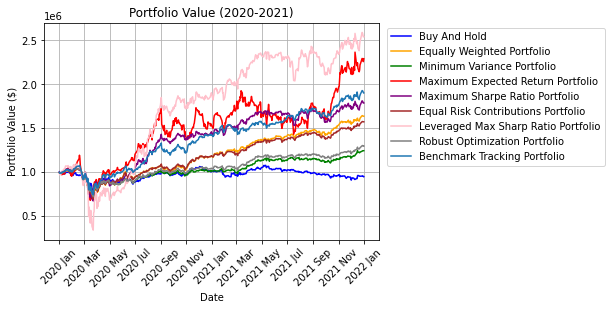

In [9]:
# Plot Line chart
# convert np.array[String] to np.array[datetime64]
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
plot_portfolio_value(portf_value, dates_array_plot , "(2020-2021)")


## Maximum Drawdown

In [10]:
def get_max_drawdown_data(N_periods, dates_array):
    start_max_drawdown=[]
    for i in range(len(strategy_functions)):
        max_drawdown=[]
        for period in range(1, N_periods+1):  
           if dates_array[0, 0] == 20:
               cur_year  = 20 + math.floor(period/7)
           else:
               cur_year  = 2020 + math.floor(period/7)

           cur_month = 2*((period-1)%6) + 1

           day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
           day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])


           #print(day_ind_end," ", day_ind_start)
           #print(np.maximum.accumulate(portf_value[i][day_ind_start-253: day_ind_end-253]))
           #print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))  
           #print(day_ind_end," ", day_ind_start)


           peak = np.maximum.accumulate(portf_value[i][day_ind_start:day_ind_end+1]) # the peak portfolio so far
           drawdown = (peak - portf_value[i][day_ind_start:day_ind_end+1])/ peak
           max_drawdown.append(np.max(drawdown))
        start_max_drawdown.append(max_drawdown)
    return start_max_drawdown
max_drawdown_data=get_max_drawdown_data(N_periods, dates_array)  

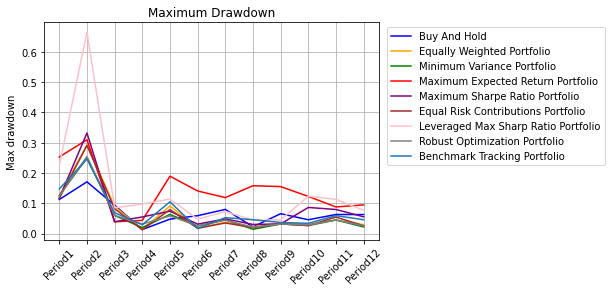

In [11]:
# function to plot portfolio value
def plot_max_drawdown(max_drawdown_data):
  # Create the plot
  x = np.arange(1, 13)  # 12 periods (1 to 12)
  #print(max_drawdown_data[0])
  plt.plot(x, max_drawdown_data[0], label="Buy And Hold", color="blue" )
  plt.plot(x, max_drawdown_data[1],label="Equally Weighted Portfolio", color="orange" )
  plt.plot(x, max_drawdown_data[2],label="Minimum Variance Portfolio", color="green" )
  plt.plot(x, max_drawdown_data[3],label="Maximum Expected Return Portfolio", color="Red" )
  plt.plot(x, max_drawdown_data[4],label="Maximum Sharpe Ratio Portfolio", color="purple" )
  plt.plot(x, max_drawdown_data[5],label="Equal Risk Contributions Portfolio", color="brown" )
  plt.plot(x, max_drawdown_data[6],label="Leveraged Max Sharp Ratio Portfolio", color="pink" )
  plt.plot(x, max_drawdown_data[7],label="Robust Optimization Portfolio", color="grey" )
  plt.plot(x, max_drawdown_data[8],label="Benchmark Tracking Portfolio")

  # Add labels and title
  #plt.xlabel("Date")
  plt.ylabel("Max drawdown")
  title = "Maximum Drawdown"
  plt.title(title)
  x_labels = [f'Period{i}' for i in range(1, 13)]


  # Rotate labels for better readability
  plt.xticks(ticks=x, labels=x_labels, rotation=45)
  plt.grid(True)
  #plt.legend()
  plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))

  # Show the plot
  plt.show()

plot_max_drawdown(max_drawdown_data)    

### Dynamic Weight

In [12]:
# Function to plot portfolio allocation
def plot_pandas_portfolio(df, strategy_name):
    #df.plot.area(figsize=(12, 6), alpha=0.8, cmap="Spectral")
    df.plot.area(figsize=(6, 3), alpha=0.8, cmap=cm.get_cmap("Spectral"))
    plt.title(f"Portfolio Allocation - {strategy_name}")
    plt.xlabel("Rolling Time Horizon")
    plt.ylabel("Portfolio Weights")
    plt.ylim(0, 1)  # Portfolio weights must sum to 1
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))
    plt.show()

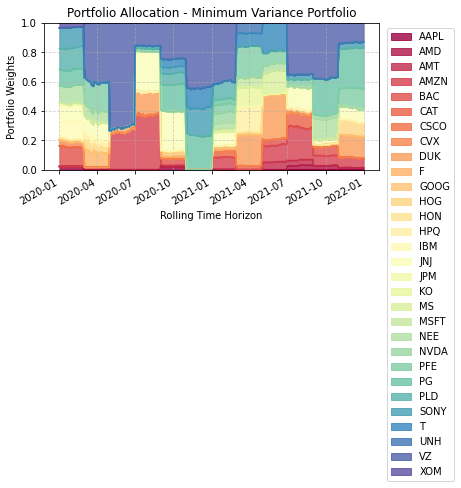

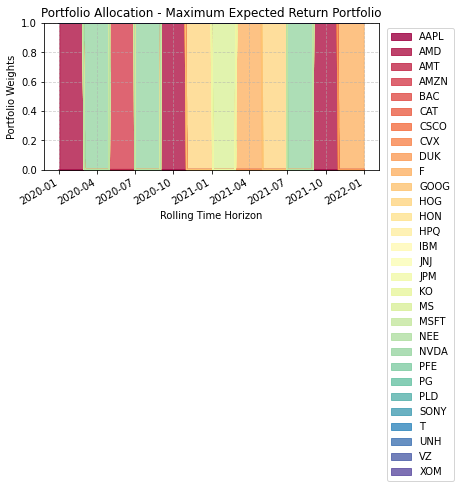

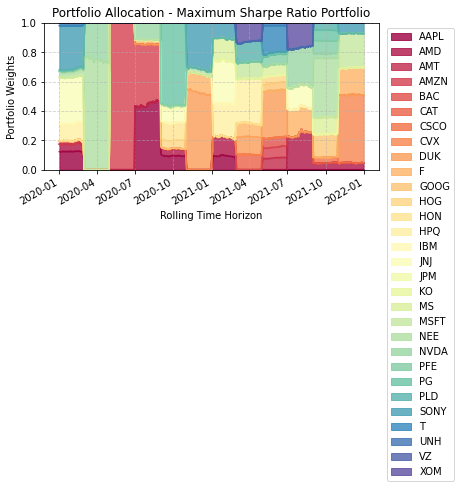

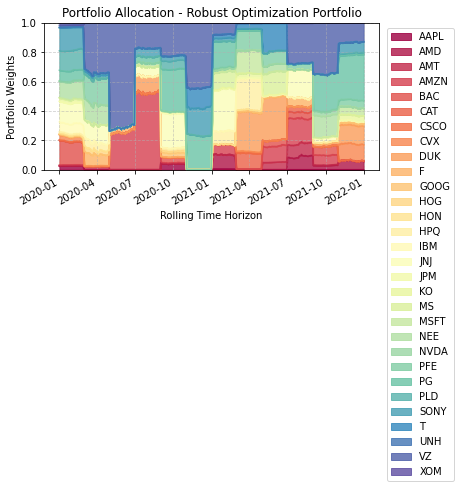

In [13]:
#time_horizon = np.arange(time_periods)
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
asset_labels = df.columns[1:]


# Convert data into a Pandas DataFrame
df_3 = pd.DataFrame(portfolio_allocation[2], columns=asset_labels, index=dates_array_plot)
df_4 = pd.DataFrame(portfolio_allocation[3], columns=asset_labels, index=dates_array_plot)
df_5 = pd.DataFrame(portfolio_allocation[4], columns=asset_labels, index=dates_array_plot)
df_8 = pd.DataFrame(portfolio_allocation[7], columns=asset_labels, index=dates_array_plot)
# df_5 = d.DataFrame(strategy_5, columns=asset_labels, index=time_horizon)


# Plot for
plot_pandas_portfolio(df_3, "Minimum Variance Portfolio")

# # Plot for Strategy 4
plot_pandas_portfolio(df_4, "Maximum Expected Return Portfolio")

# # Plot for Strategy 5
plot_pandas_portfolio(df_5, "Maximum Sharpe Ratio Portfolio")

# # Plot for Strategy 8
plot_pandas_portfolio(df_8, "Robust Optimization Portfolio")

# trading strategies for years 2008 and 2009:

In [14]:
########## Data Source ##########
# Input file
input_file_prices = 'adjclose_2008_2009.csv' # path to close_2020_2021

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

num_stocks = 30

# Weights of assets in the benchmark portfolio S&P30 for years 2008-2009
w_b2008_2009 = np.array([0.04515391, 0.09628167, 0.00962156, 0.04751553, 0.02738386, 0.00612178, 0.03599232, 0.00710205, 0.02258147, 0.03947036, 0.11549755, 0.02968896, 0.04899179, 0.02151471, 0.03012594, 0.02472594, 0.00728987, 0.00204819, 0.03935471, 0.052657, 0.11181873, 0.04252905, 0.00758877, 0.01545498, 0.03195875, 0.03585342, 0.01304049, 0.01117294, 0.01060861, 0.01085508])

class config(object):
    def __init__ (self, commission_rate, num_stocks, r_rf, portf_retn,rob_bnd, w_b ):
        self.commission_rate = commission_rate
        self.num_stocks = num_stocks
        self.r_rf = r_rf
        self.portf_retn = portf_retn
        self.rob_bnd=rob_bnd
        self.w_b = w_b
        

config= config(0.005,  num_stocks, r_rf2008_2009, 0.015, 0.005, w_b2008_2009)

In [15]:
class debt(object):
    def __init__(self, interest):
        self.amount=0.0
        self.interest = interest
        
    def renew_debt(self, amount):
        self.amount = amount
        
debt = debt(config.r_rf)

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim', 'strat_tracking_index']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
N_strat = 9  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index]


portfolio_allocation = np.zeros((N_strat, N_days, num_stocks),  dtype=np.ndarray)
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code
#    if dates_array[0, 0] == 20:
#        cur_year  = 20 + math.floor(period/7)
#    else:
#        cur_year  = 2020 + math.floor(period/7)

   # example for 2008-2009 data
   if dates_array[0, 0] == 8:
      cur_year  = 8 + math.floor(period/7)
   else:
      cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
    if period == 1:
        curr_positions = init_positions
        curr_cash = 0
        portf_value[strategy] = np.zeros((N_days, 1))
    else:
        curr_positions = x[strategy, period-2]
        curr_cash = cash[strategy, period-2]

    # Compute strategy
    x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

    # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
    # Check that cash account is >= 0
    # Check that we can buy new portfolio subject to transaction costs

    ###################### Insert your code here ############################
    if cash[strategy, period-1] < 0 :
        x[strategy, period-1], cash[strategy, period-1] = handle_insufficient_budget(curr_positions, x[strategy, period-1], cur_prices, cash[strategy, period-1], curr_cash)

    # throw exception is cash less than 0
    if cash[strategy, period-1] < 0:
        raise ValueError("Negative cash balance is not allowed")


    # Compute portfolio value
    p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
    portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
    
    # deducted the debt and interest
    if strategy_names[strategy] == "Leveraged Max Sharpe Ratio Portfolio":
        portf_value[strategy][day_ind_start:day_ind_end+1] = portf_value[strategy][day_ind_start:day_ind_end+1]-debt.amount
        
    print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))
    
    portfolio_allocation[strategy][day_ind_start:day_ind_end+1] = data_prices[day_ind_start:day_ind_end+1,:]* x[strategy, period-1] / np.reshape(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]), (p_values.size,1))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 431667.19


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 431667.19, value end = $ 362791.58, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 427657.62, value end = $ 380549.73, cash account = $412.77
  Strategy "Mininum Variance Portfolio", value begin = $ 427372.58, value end = $ 395623.19, cash account = $118.72
  Strategy "Maximum Expected Return Portfolio", value begin = $ 427372.13, value end = $ 350529.86, cash account = $27.18
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 427372.19, value end = $ 350311.26, cash account = $39.80
Objective value at iteration #0 is - 1.58669e-06
Objective value at iteration #1 is - 1.58667e-06
Objective value at iteration #2 is - 5.33455e-07
Objective value at iteration #3 is - 5.33309e-07
Objective value at iteration #4 is - 4.30953e-08
Objective value at iteration #5 is - 4.30258e-08
Objective value at iteration #6 is - 1.

  Strategy "Benchmark Tracking Portfolio", value begin = $ 350471.31, value end = $ 334738.51, cash account = $102.28

Period 5: start date 09/02/2008, end date 10/31/2008
  Strategy "Buy and Hold", value begin = $ 377133.17, value end = $ 294175.02, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 369416.70, value end = $ 279432.30, cash account = $172.85
  Strategy "Mininum Variance Portfolio", value begin = $ 416319.62, value end = $ 346670.22, cash account = $60.38
  Strategy "Maximum Expected Return Portfolio", value begin = $ 298721.14, value end = $ 225702.64, cash account = $17.25
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 290604.40, value end = $ 249725.31, cash account = $112.79
Objective value at iteration #0 is - 4.52044e-08
Objective value at iteration #1 is - 4.52044e-08
Objective value at iteration #2 is - 8.15092e-08
Objective value at iteration #3 is - 8.18877e-08
Objective value at iteration #4 is - 8.19123e-08
Objective 

Objective value at iteration #14 is - 8.7815e-10
Objective value at iteration #15 is - 5.85865e-10
Objective value at iteration #16 is - 3.4411e-10
Objective value at iteration #17 is - 2.50106e-10
Objective value at iteration #18 is - 1.28909e-10
Objective value at iteration #19 is - 5.25037e-11
Objective value at iteration #20 is - 2.61277e-11
Objective value at iteration #21 is - 1.63623e-11
Objective value at iteration #22 is - 1.10567e-11
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 234867.70, value end = $ 307857.77, cash account = $219.24
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ -217546.35, value end = $ -152568.33, cash account = $21.21
  Strategy "Robust Optimization Portfolio", value begin = $ 278423.04, value end = $ 305315.71, cash account = $141.40
  Strategy "Benchmark Tracking Portfolio", value begin = $ 189372.06, value end = $ 260827.41, cash account = $37.60

Period 9: start date 05/01/2009, end date 06/30/2009
  Strategy 

Objective value at iteration #5 is - 1.04655e-08
Objective value at iteration #6 is - 4.85355e-09
Objective value at iteration #7 is - 1.91362e-09
Objective value at iteration #8 is - 7.90197e-10
Objective value at iteration #9 is - 3.60832e-10
Objective value at iteration #10 is - 2.62733e-10
Objective value at iteration #11 is - 1.39876e-10
Objective value at iteration #12 is - 1.19709e-10
Objective value at iteration #13 is - 7.52876e-11
Objective value at iteration #14 is - 7.20299e-11
Objective value at iteration #15 is - 3.28111e-11
Objective value at iteration #16 is - 1.40016e-11
Objective value at iteration #17 is - 4.56753e-12
Objective value at iteration #18 is - 3.22876e-12
Objective value at iteration #19 is - 1.89647e-12
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 371227.11, value end = $ 410735.66, cash account = $575.25
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ -150933.94, value end = $ -124907.32, cash account = $67.70
  St

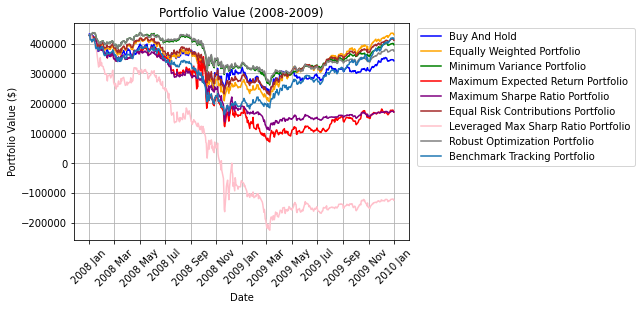

In [16]:
# Plot Line chart
# convert np.array[String] to np.array[datetime64]
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
plot_portfolio_value(portf_value, dates_array_plot , "(2008-2009)")

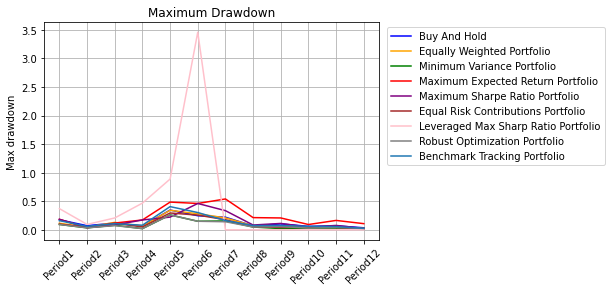

In [17]:
def get_max_drawdown_data_2008(N_periods, dates_array):
    start_max_drawdown=[]
    for i in range(len(strategy_functions)):
        max_drawdown=[]
        for period in range(1, N_periods+1):  
           if dates_array[0, 0] == 8:
              cur_year  = 8 + math.floor(period/7)
           else:
              cur_year  = 2008 + math.floor(period/7)

           cur_month = 2*((period-1)%6) + 1

           day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
           day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])


           #print(day_ind_end," ", day_ind_start)
           #print(np.maximum.accumulate(portf_value[i][day_ind_start-253: day_ind_end-253]))
           #print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))  
           #print(day_ind_end," ", day_ind_start)


           peak = np.maximum.accumulate(portf_value[i][day_ind_start:day_ind_end+1]) # the peak portfolio so far
           drawdown = (peak - portf_value[i][day_ind_start:day_ind_end+1])/ peak
           max_drawdown.append(np.max(drawdown))
        start_max_drawdown.append(max_drawdown)
    return start_max_drawdown

# Plot max drawdown
max_drawdown_data=get_max_drawdown_data_2008(N_periods, dates_array)  
plot_max_drawdown(max_drawdown_data)  

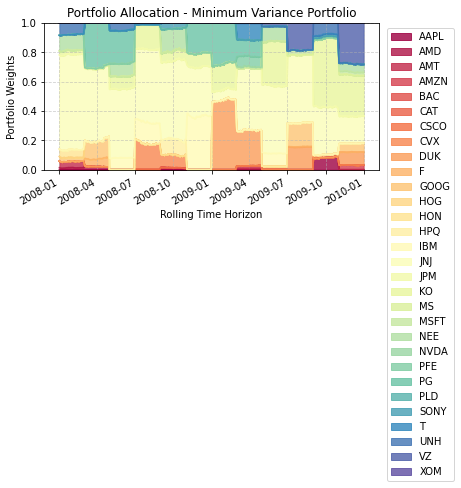

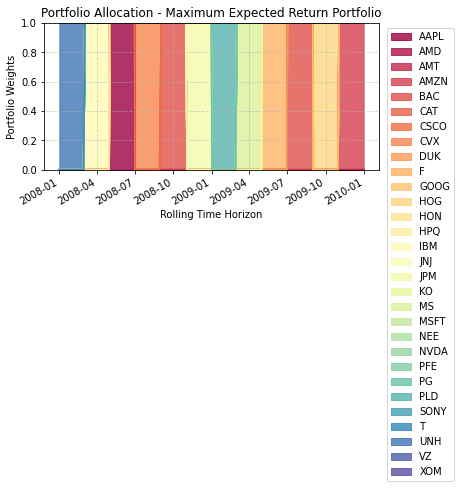

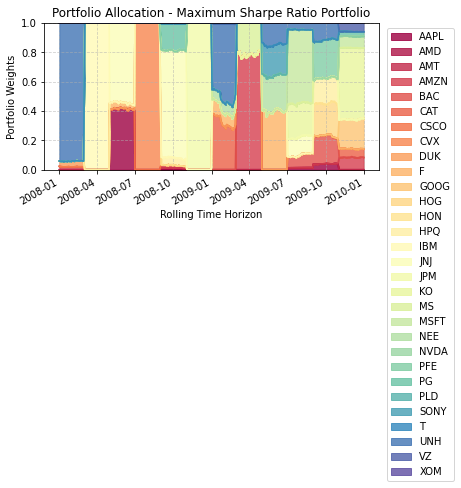

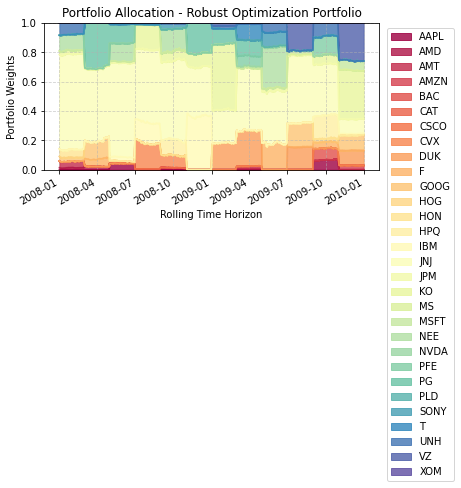

In [18]:
#time_horizon = np.arange(time_periods)
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
asset_labels = df.columns[1:]


# Convert data into a Pandas DataFrame
df_3 = pd.DataFrame(portfolio_allocation[2], columns=asset_labels, index=dates_array_plot)
df_4 = pd.DataFrame(portfolio_allocation[3], columns=asset_labels, index=dates_array_plot)
df_5 = pd.DataFrame(portfolio_allocation[4], columns=asset_labels, index=dates_array_plot)
df_8 = pd.DataFrame(portfolio_allocation[7], columns=asset_labels, index=dates_array_plot)
# df_5 = d.DataFrame(strategy_5, columns=asset_labels, index=time_horizon)


# Plot for
plot_pandas_portfolio(df_3, "Minimum Variance Portfolio")

# # Plot for Strategy 4
plot_pandas_portfolio(df_4, "Maximum Expected Return Portfolio")

# # Plot for Strategy 5
plot_pandas_portfolio(df_5, "Maximum Sharpe Ratio Portfolio")

# # Plot for Strategy 8
plot_pandas_portfolio(df_8, "Robust Optimization Portfolio")

# trading strategies for year 2022

In [19]:
########## Data Source ##########
# Input file
input_file_prices = 'adjclose_2022.csv' # path to close_2020_2021

# Read data into a dataframe
df = pd.read_csv(input_file_prices)


r_rf2022 = 0.0375
num_stocks = 30

# Weights of assets in the benchmark portfolio S&P30 for year 2022
w_b2022 = np.array([0.1994311, 0.18518391, 0.05464191, 0.06021769, 0.00822679, 0.01771958, 0.01735487, 0.00242781, 0.0111223 , 0.03079034, 0.02378042, 0.01075559, 0.02868988, 0.03363043, 0.02184145, 0.13425809, 0.00503211, 0.00034546, 0.0177085 , 0.02689907, 0.01820472, 0.0139343 , 0.00946646, 0.01088172, 0.00821592, 0.01352356, 0.00966943, 0.00712117, 0.01347266, 0.00545276])


class config(object):
    def __init__ (self, commission_rate, num_stocks, r_rf, portf_retn,rob_bnd, w_b ):
        self.commission_rate = commission_rate
        self.num_stocks = num_stocks
        self.r_rf = r_rf
        self.portf_retn = portf_retn
        self.rob_bnd=rob_bnd
        self.w_b = w_b
        
config= config(0.005,  num_stocks, r_rf2022, 0.15, 0.005, w_b2022)

In [20]:
class debt(object):
    def __init__(self, interest):
        self.amount=0.0
        self.interest = interest
        
    def renew_debt(self, amount):
        self.amount = amount
        
debt = debt(config.r_rf)


dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim', 'strat_tracking_index']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
N_strat = 9  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index]


portfolio_allocation = np.zeros((N_strat, N_days, num_stocks),  dtype=np.ndarray)
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   cur_year = 2022
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code
#    if dates_array[0, 0] == 20:
#        cur_year  = 20 + math.floor(period/7)
#    else:
#        cur_year  = 2020 + math.floor(period/7)

   # example for 2008-2009 data
#    if dates_array[0, 0] == 8:
#       cur_year  = 8 + math.floor(period/7)
#    else:
#       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
    if period == 1:
        curr_positions = init_positions
        curr_cash = 0
        portf_value[strategy] = np.zeros((N_days, 1))
    else:
        curr_positions = x[strategy, period-2]
        curr_cash = cash[strategy, period-2]

    # Compute strategy
    x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

    # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
    # Check that cash account is >= 0
    # Check that we can buy new portfolio subject to transaction costs

    ###################### Insert your code here ############################
    if cash[strategy, period-1] < 0 :
        x[strategy, period-1], cash[strategy, period-1] = handle_insufficient_budget(curr_positions, x[strategy, period-1], cur_prices, cash[strategy, period-1], curr_cash)

    # throw exception is cash less than 0
    if cash[strategy, period-1] < 0:
        raise ValueError("Negative cash balance is not allowed")


    # Compute portfolio value
    p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
    portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
    
    # deducted the debt and interest
    if strategy_names[strategy] == "Leveraged Max Sharpe Ratio Portfolio":
        portf_value[strategy][day_ind_start:day_ind_end+1] = portf_value[strategy][day_ind_start:day_ind_end+1]-debt.amount*(1+(debt.interest/12 *2))
        
    print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))
    
    portfolio_allocation[strategy][day_ind_start:day_ind_end+1] = data_prices[day_ind_start:day_ind_end+1,:]* x[strategy, period-1] / np.reshape(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]), (p_values.size,1))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 950205.84


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 950205.84, value end = $ 992093.09, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 941384.79, value end = $ 879062.82, cash account = $1788.78
  Strategy "Mininum Variance Portfolio", value begin = $ 944111.34, value end = $ 910355.96, cash account = $766.42
  Strategy "Maximum Expected Return Portfolio", value begin = $ 940751.46, value end = $ 785443.70, cash account = $82.23
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 940752.36, value end = $ 860358.54, cash account = $261.70
Objective value at iteration #0 is - 5.10405e-07
Objective value at iteration #1 is - 5.10397e-07
Objective value at iteration #2 is - 2.14131e-07
Objective value at iteration #3 is - 2.14097e-07
Objective value at iteration #4 is - 1.38144e-08
Objective value at iteration #5 is - 1.37953e-08
Objective value at iteration #6 is - 

  Strategy "Robust Optimization Portfolio", value begin = $ 904391.72, value end = $ 824345.37, cash account = $285.79
  Strategy "Benchmark Tracking Portfolio", value begin = $ 713439.29, value end = $ 751301.70, cash account = $545.21

Period 5: start date 09/01/2022, end date 10/31/2022
  Strategy "Buy and Hold", value begin = $ 809906.04, value end = $ 763840.81, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 824436.82, value end = $ 808050.39, cash account = $1400.78
  Strategy "Mininum Variance Portfolio", value begin = $ 829134.89, value end = $ 862426.95, cash account = $421.52
  Strategy "Maximum Expected Return Portfolio", value begin = $ 726186.83, value end = $ 639184.13, cash account = $48.62
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 708960.82, value end = $ 648574.86, cash account = $270.58
Objective value at iteration #0 is - 2.03772e-09
Objective value at iteration #1 is - 2.03775e-09
Objective value at iteration #2 is -

In [21]:
config.r_rf

0.0375

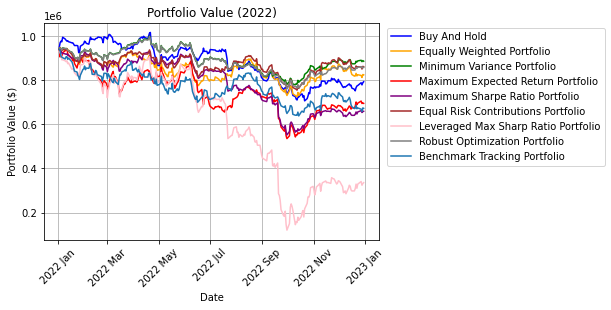

In [22]:
# Plot Line chart
# convert np.array[String] to np.array[datetime64]
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
plot_portfolio_value(portf_value, dates_array_plot , "(2022)")

[[0.07023202410195113, 0.14714007641663682, 0.06425654743875601, 0.13898561858185285, 0.15937478007682224, 0.07042413679045122], [0.09696492419609738, 0.09416494921394769, 0.12162811953890988, 0.07973611759173424, 0.14608386756413008, 0.07022876869980707], [0.06003859336398264, 0.06071182384985307, 0.11755005736101108, 0.08810507019662567, 0.07082153696804412, 0.021394684864875318], [0.1830948192429032, 0.12359088230789121, 0.22245241082662007, 0.06073816579175777, 0.279261042909582, 0.04201258211394035], [0.10068684109583255, 0.0632731119363393, 0.11949877162851695, 0.15822225496205328, 0.24205726953771553, 0.05333511801317898], [0.08971576886175821, 0.06708226295782996, 0.11281982645410894, 0.07018547681748907, 0.1321313236968682, 0.05616951115233574], [0.20452158625778816, 0.1313968232172084, 0.2500922794484809, 0.3642808929387523, 0.7511343257231117, 0.20374749107608536], [0.061010811875237735, 0.060447650039015706, 0.11739075406951731, 0.08850849920510544, 0.10443055558619278, 0.0

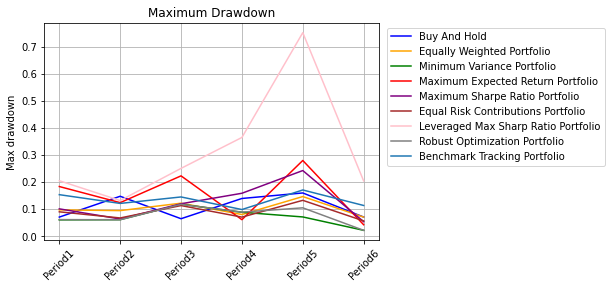

In [23]:
# Plot max drawdown

def get_max_drawdown_data_2022(N_periods, dates_array):
    start_max_drawdown=[]
    for i in range(len(strategy_functions)):
        max_drawdown=[]
        for period in range(1, N_periods+1):  
           cur_year = 2022

           cur_month = 2*((period-1)%6) + 1

           day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
           day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])


           #print(day_ind_end," ", day_ind_start)
           #print(np.maximum.accumulate(portf_value[i][day_ind_start-253: day_ind_end-253]))
           #print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))  
           #print(day_ind_end," ", day_ind_start)


           peak = np.maximum.accumulate(portf_value[i][day_ind_start:day_ind_end+1]) # the peak portfolio so far
           drawdown = (peak - portf_value[i][day_ind_start:day_ind_end+1])/ peak
           max_drawdown.append(np.max(drawdown))
        start_max_drawdown.append(max_drawdown)
    return start_max_drawdown

# function to plot portfolio value
def plot_max_drawdown(max_drawdown_data):
  # Create the plot
  x = np.arange(1, 7)  # 12 periods (1 to 12)
  #print(max_drawdown_data[0])
  plt.plot(x, max_drawdown_data[0], label="Buy And Hold", color="blue" )
  plt.plot(x, max_drawdown_data[1],label="Equally Weighted Portfolio", color="orange" )
  plt.plot(x, max_drawdown_data[2],label="Minimum Variance Portfolio", color="green" )
  plt.plot(x, max_drawdown_data[3],label="Maximum Expected Return Portfolio", color="Red" )
  plt.plot(x, max_drawdown_data[4],label="Maximum Sharpe Ratio Portfolio", color="purple" )
  plt.plot(x, max_drawdown_data[5],label="Equal Risk Contributions Portfolio", color="brown" )
  plt.plot(x, max_drawdown_data[6],label="Leveraged Max Sharp Ratio Portfolio", color="pink" )
  plt.plot(x, max_drawdown_data[7],label="Robust Optimization Portfolio", color="grey" )
  plt.plot(x, max_drawdown_data[8],label="Benchmark Tracking Portfolio")

  # Add labels and title
  #plt.xlabel("Date")
  plt.ylabel("Max drawdown")
  title = "Maximum Drawdown"
  plt.title(title)
  x_labels = [f'Period{i}' for i in range(1, 7)]


  # Rotate labels for better readability
  plt.xticks(ticks=x, labels=x_labels, rotation=45)
  plt.grid(True)
  #plt.legend()
  plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))

  # Show the plot
  plt.show()

max_drawdown_data=get_max_drawdown_data_2022(N_periods, dates_array)  
print(max_drawdown_data)
plot_max_drawdown(max_drawdown_data)  

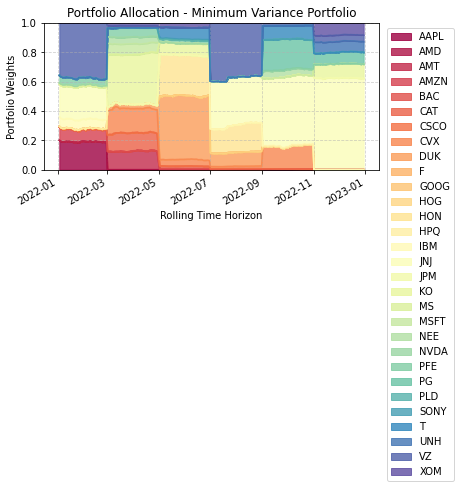

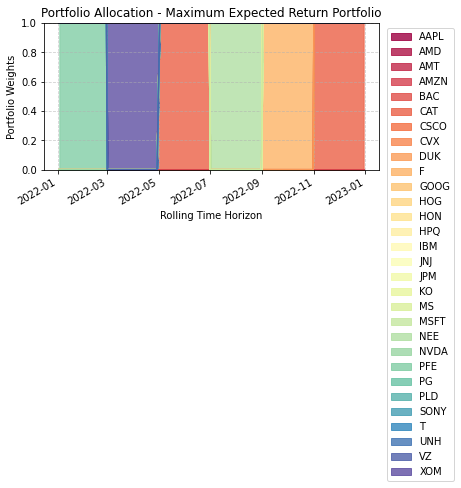

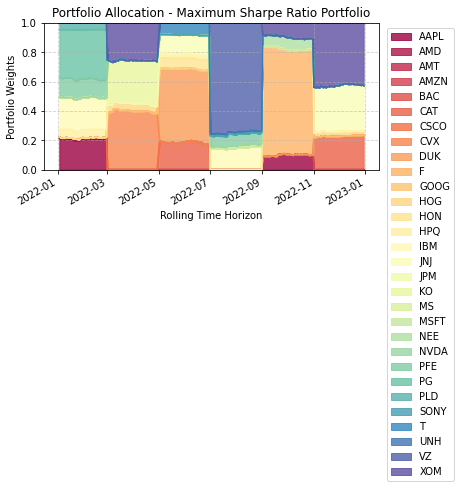

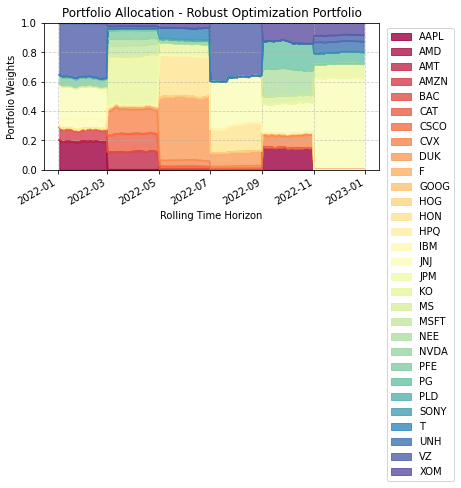

In [24]:
#time_horizon = np.arange(time_periods)
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
asset_labels = df.columns[1:]


# Convert data into a Pandas DataFrame
df_3 = pd.DataFrame(portfolio_allocation[2], columns=asset_labels, index=dates_array_plot)
df_4 = pd.DataFrame(portfolio_allocation[3], columns=asset_labels, index=dates_array_plot)
df_5 = pd.DataFrame(portfolio_allocation[4], columns=asset_labels, index=dates_array_plot)
df_8 = pd.DataFrame(portfolio_allocation[7], columns=asset_labels, index=dates_array_plot)
# df_5 = d.DataFrame(strategy_5, columns=asset_labels, index=time_horizon)


# Plot for
plot_pandas_portfolio(df_3, "Minimum Variance Portfolio")

# # Plot for Strategy 4
plot_pandas_portfolio(df_4, "Maximum Expected Return Portfolio")

# # Plot for Strategy 5
plot_pandas_portfolio(df_5, "Maximum Sharpe Ratio Portfolio")

# # Plot for Strategy 8
plot_pandas_portfolio(df_8, "Robust Optimization Portfolio")